# Fraud Detection Project - Model Building and Evaluation
## 10 Academy: Artificial Intelligence Mastery Week 8&9 Challenge

---

## Table of Contents
1. [Setup and Data Loading](#1-setup-and-data-loading)
2. [Data Preparation for Modeling](#2-data-preparation-for-modeling)
3. [Baseline Models](#3-baseline-models)
4. [SMOTE Implementation](#4-smote-implementation)
5. [Advanced Models](#5-advanced-models)
6. [Model Evaluation](#6-model-evaluation)
7. [Model Comparison](#7-model-comparison)
8. [Business Impact Analysis](#8-business-impact-analysis)
9. [Model Selection and Recommendations](#9-model-selection-and-recommendations)

---

## 1. Setup and Data Loading

In [ ]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Metrics
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    average_precision_score, precision_recall_curve, roc_curve,
    f1_score, precision_score, recall_score
)

# Imbalanced learning
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline

# Advanced models
import xgboost as xgb
import lightgbm as lgb

print("✅ All libraries imported successfully!")
print(f"🚀 Model building started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ All libraries imported successfully!
🚀 Model building started at: 2025-07-26 16:13:18


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
# Load processed data
try:
    df = pd.read_csv('/content/drive/MyDrive/kaim 6/week8/data/processed/fraud_data_processed.csv')
    print(f"✅ Loaded processed data: {df.shape}")
except FileNotFoundError:
    print("⚠️ Processed data not found. Creating sample data...")

print(f"📊 Dataset info:")
print(f"   Shape: {df.shape}")
print(f"   Fraud rate: {df['class'].mean()*100:.2f}%")
print(f"   Features: {df.columns.tolist()}")

✅ Loaded processed data: (151112, 30)
📊 Dataset info:
   Shape: (151112, 30)
   Fraud rate: 9.36%
   Features: ['user_id', 'signup_time', 'purchase_time', 'purchase_value', 'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class', 'ip_address_int', 'hour', 'day_of_week', 'is_weekend', 'is_night', 'time_since_signup', 'is_new_user', 'is_high_value', 'user_transaction_count', 'user_total_value', 'user_avg_value', 'user_unique_devices', 'device_transaction_count', 'device_total_value', 'device_unique_users', 'is_shared_device', 'is_young_user', 'is_ad_source', 'country']


## 2. Data Preparation for Modeling

In [ ]:
def prepare_modeling_data(df, target_col='class'):
    """
    Prepare data for machine learning modeling
    """
    print("🔧 PREPARING DATA FOR MODELING")
    print("=" * 35)

    # Select features for modeling
    feature_columns = [
        'purchase_value', 'age', 'hour', 'is_weekend', 'is_night',
        'time_since_signup', 'is_new_user', 'is_high_value',
        'user_transaction_count', 'device_unique_users', 'is_shared_device',
        'is_young_user', 'is_ad_source', 'source_encoded', 'browser_encoded', 'sex_encoded'
    ]

    # Select available features
    available_features = [col for col in feature_columns if col in df.columns]
    X = df[available_features]
    y = df[target_col]

    print(f"✅ Selected {len(available_features)} features:")
    for i, feature in enumerate(available_features, 1):
        print(f"   {i:2d}. {feature}")

    print(f"\n📊 Target distribution:")
    print(f"   Non-fraud: {(y==0).sum():,} ({(y==0).mean()*100:.2f}%)")
    print(f"   Fraud: {(y==1).sum():,} ({(y==1).mean()*100:.2f}%)")
    print(f"   Imbalance ratio: {(y==0).sum()/(y==1).sum():.1f}:1")

    return X, y, available_features

# Prepare data
X, y, feature_names = prepare_modeling_data(df)

🔧 PREPARING DATA FOR MODELING
✅ Selected 13 features:
    1. purchase_value
    2. age
    3. hour
    4. is_weekend
    5. is_night
    6. time_since_signup
    7. is_new_user
    8. is_high_value
    9. user_transaction_count
   10. device_unique_users
   11. is_shared_device
   12. is_young_user
   13. is_ad_source

📊 Target distribution:
   Non-fraud: 136,961 (90.64%)
   Fraud: 14,151 (9.36%)
   Imbalance ratio: 9.7:1


In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"📊 DATA SPLIT:")
print(f"   Training set: {X_train.shape}")
print(f"   Test set: {X_test.shape}")
print(f"   Train fraud rate: {y_train.mean()*100:.2f}%")
print(f"   Test fraud rate: {y_test.mean()*100:.2f}%")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ Features scaled using StandardScaler")

📊 DATA SPLIT:
   Training set: (120889, 13)
   Test set: (30223, 13)
   Train fraud rate: 9.36%
   Test fraud rate: 9.36%

✅ Features scaled using StandardScaler


## 3. Baseline Models

In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Comprehensive model evaluation
    """
    print(f"\n📊 EVALUATING {model_name.upper()}")
    print("-" * (15 + len(model_name)))

    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Metrics
    auc_roc = roc_auc_score(y_test, y_proba)
    auc_pr = average_precision_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"AUC-PR:  {auc_pr:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix:")
    print(f"   TN: {cm[0,0]:4d}  FP: {cm[0,1]:4d}")
    print(f"   FN: {cm[1,0]:4d}  TP: {cm[1,1]:4d}")

    return {
        'model_name': model_name,
        'auc_roc': auc_roc,
        'auc_pr': auc_pr,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'confusion_matrix': cm
    }

# Baseline models without SMOTE
print("🎯 BASELINE MODELS (WITHOUT SMOTE)")
print("=" * 38)

baseline_results = []

# 1. Logistic Regression
lr_baseline = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
lr_baseline.fit(X_train_scaled, y_train)
lr_baseline_results = evaluate_model(lr_baseline, X_train_scaled, X_test_scaled, y_train, y_test, "Logistic Regression")
baseline_results.append(lr_baseline_results)

# 2. Random Forest
rf_baseline = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_baseline.fit(X_train, y_train)
rf_baseline_results = evaluate_model(rf_baseline, X_train, X_test, y_train, y_test, "Random Forest")
baseline_results.append(rf_baseline_results)

# 3. XGBoost
xgb_baseline = xgb.XGBClassifier(
    n_estimators=100,
    random_state=42,
    scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),
    eval_metric='logloss'
)
xgb_baseline.fit(X_train, y_train)
xgb_baseline_results = evaluate_model(xgb_baseline, X_train, X_test, y_train, y_test, "XGBoost")
baseline_results.append(xgb_baseline_results)

🎯 BASELINE MODELS (WITHOUT SMOTE)

📊 EVALUATING LOGISTIC REGRESSION
----------------------------------
AUC-ROC: 0.8390
AUC-PR:  0.7062
F1-Score: 0.6104
Precision: 0.5334
Recall: 0.7134

Confusion Matrix:
   TN: 25627  FP: 1766
   FN:  811  TP: 2019

📊 EVALUATING RANDOM FOREST
----------------------------
AUC-ROC: 0.8394
AUC-PR:  0.6896
F1-Score: 0.6875
Precision: 0.9710
Recall: 0.5322

Confusion Matrix:
   TN: 27348  FP:   45
   FN: 1324  TP: 1506

📊 EVALUATING XGBOOST
----------------------
AUC-ROC: 0.8415
AUC-PR:  0.7061
F1-Score: 0.6095
Precision: 0.5462
Recall: 0.6894

Confusion Matrix:
   TN: 25772  FP: 1621
   FN:  879  TP: 1951



📊 VISUALIZING BASELINE MODEL RESULTS


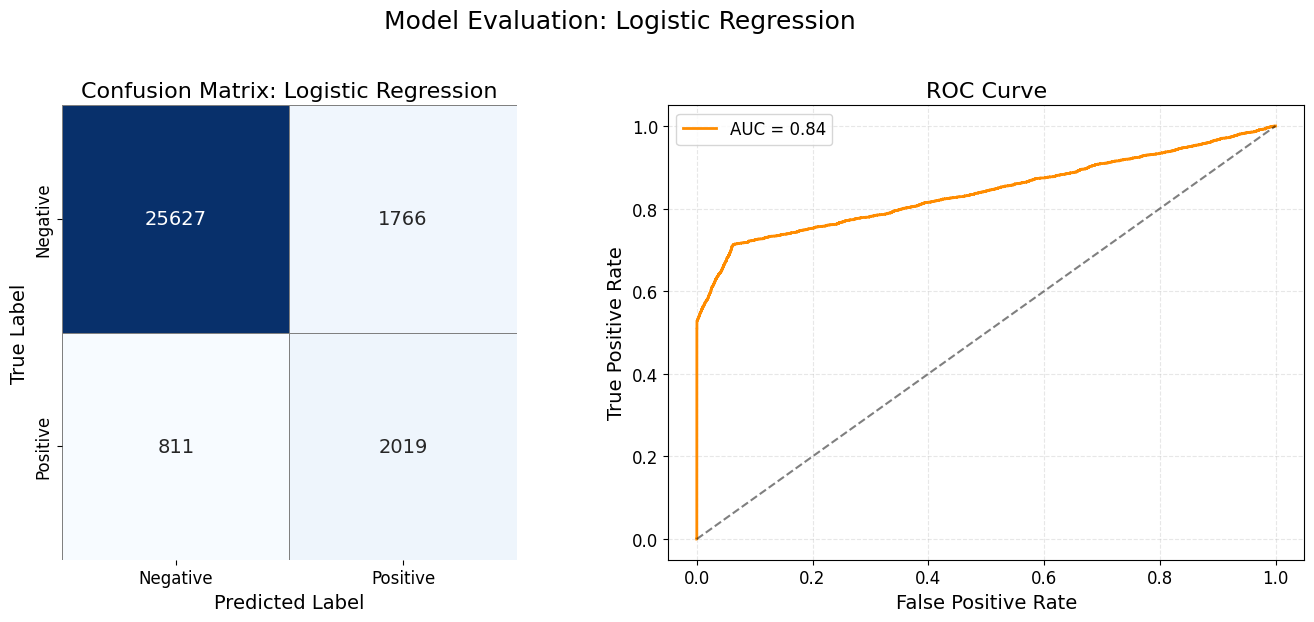

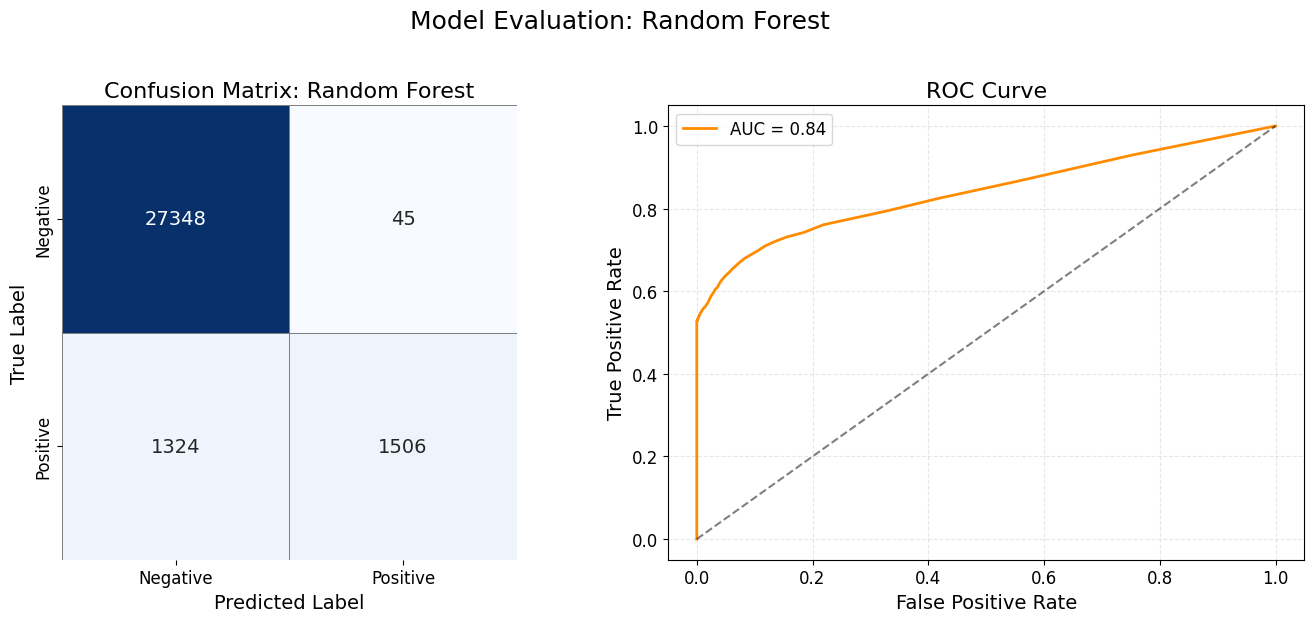

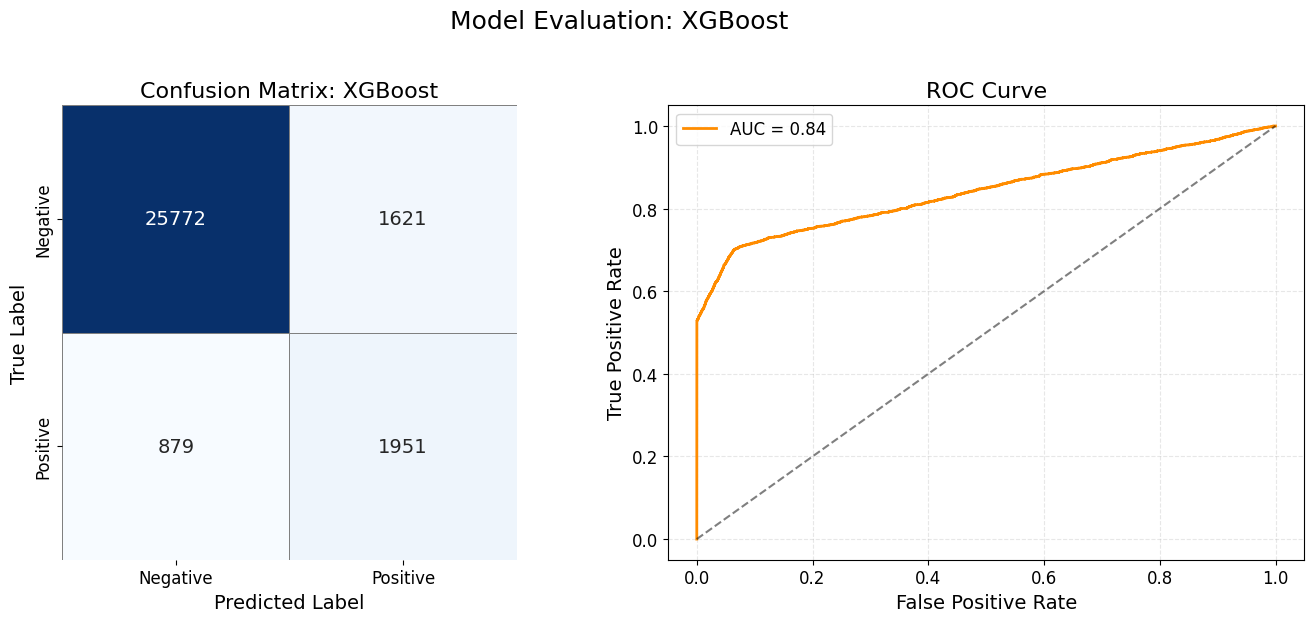

In [ ]:
def plot_model_results(cm, y_test, y_proba, model_name, class_labels=None):
    """
    Plots confusion matrix and ROC curve side by side for a model.
    """
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
                xticklabels=class_labels if class_labels else 'auto',
                yticklabels=class_labels if class_labels else 'auto',
                linewidths=0.5, linecolor='gray', ax=axes[0],
                annot_kws={"size": 14})

    axes[0].set_title(f'Confusion Matrix: {model_name}', fontsize=16)
    axes[0].set_xlabel('Predicted Label', fontsize=14)
    axes[0].set_ylabel('True Label', fontsize=14)
    axes[0].tick_params(axis='both', labelsize=12)

    # ROC Curve
    axes[1].plot(fpr, tpr, label=f'AUC = {auc_score:.2f}', color='darkorange', linewidth=2)
    axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    axes[1].set_title('ROC Curve', fontsize=16)
    axes[1].set_xlabel('False Positive Rate', fontsize=14)
    axes[1].set_ylabel('True Positive Rate', fontsize=14)
    axes[1].legend(fontsize=12)
    axes[1].grid(True, linestyle='--', alpha=0.3)
    axes[1].tick_params(axis='both', labelsize=12)

    plt.suptitle(f'Model Evaluation: {model_name}', fontsize=18, y=1.03)
    plt.tight_layout()
    plt.show()

# Visualize all models
print("\n📊 VISUALIZING BASELINE MODEL RESULTS")
print("=" * 38)

# Optional class labels
class_labels = ['Negative', 'Positive']  # or your actual classes

for result in baseline_results:
    plot_model_results(result['confusion_matrix'], y_test, result['y_proba'], result['model_name'], class_labels)


## 4. SMOTE Implementation

In [ ]:
print("🔄 IMPLEMENTING SMOTE STRATEGY")
print("=" * 32)

# SMOTE configuration
smote_configs = {
    'SMOTE_30': SMOTE(sampling_strategy=0.3, random_state=42),
    'SMOTE_50': SMOTE(sampling_strategy=0.5, random_state=42),
    'ADASYN': ADASYN(sampling_strategy=0.3, random_state=42),
    'SMOTEENN': SMOTEENN(sampling_strategy=0.3, random_state=42)
}

smote_results = []

for config_name, sampler in smote_configs.items():
    print(f"\n🔄 Testing {config_name}...")

    # Apply sampling
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)

    print(f"   Original: {X_train.shape[0]:,} samples")
    print(f"   Resampled: {X_resampled.shape[0]:,} samples")
    print(f"   New fraud rate: {y_resampled.mean()*100:.1f}%")

    # Train Random Forest with resampled data
    rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_smote.fit(X_resampled, y_resampled)

    # Evaluate
    results = evaluate_model(rf_smote, X_resampled, X_test, y_resampled, y_test, f"RF + {config_name}")
    smote_results.append(results)

🔄 IMPLEMENTING SMOTE STRATEGY

🔄 Testing SMOTE_30...
   Original: 120,889 samples
   Resampled: 142,438 samples
   New fraud rate: 23.1%

📊 EVALUATING RF + SMOTE_30
----------------------------
AUC-ROC: 0.8280
AUC-PR:  0.6729
F1-Score: 0.6604
Precision: 0.8276
Recall: 0.5495

Confusion Matrix:
   TN: 27069  FP:  324
   FN: 1275  TP: 1555

🔄 Testing SMOTE_50...
   Original: 120,889 samples
   Resampled: 164,352 samples
   New fraud rate: 33.3%

📊 EVALUATING RF + SMOTE_50
----------------------------
AUC-ROC: 0.8241
AUC-PR:  0.6642
F1-Score: 0.6253
Precision: 0.6979
Recall: 0.5664

Confusion Matrix:
   TN: 26699  FP:  694
   FN: 1227  TP: 1603

🔄 Testing ADASYN...
   Original: 120,889 samples
   Resampled: 140,695 samples
   New fraud rate: 22.1%

📊 EVALUATING RF + ADASYN
--------------------------
AUC-ROC: 0.8246
AUC-PR:  0.6662
F1-Score: 0.6278
Precision: 0.6998
Recall: 0.5693

Confusion Matrix:
   TN: 26702  FP:  691
   FN: 1219  TP: 1611

🔄 Testing SMOTEENN...
   Original: 120,889 sa


📊 VISUALIZING SMOTE MODEL RESULTS


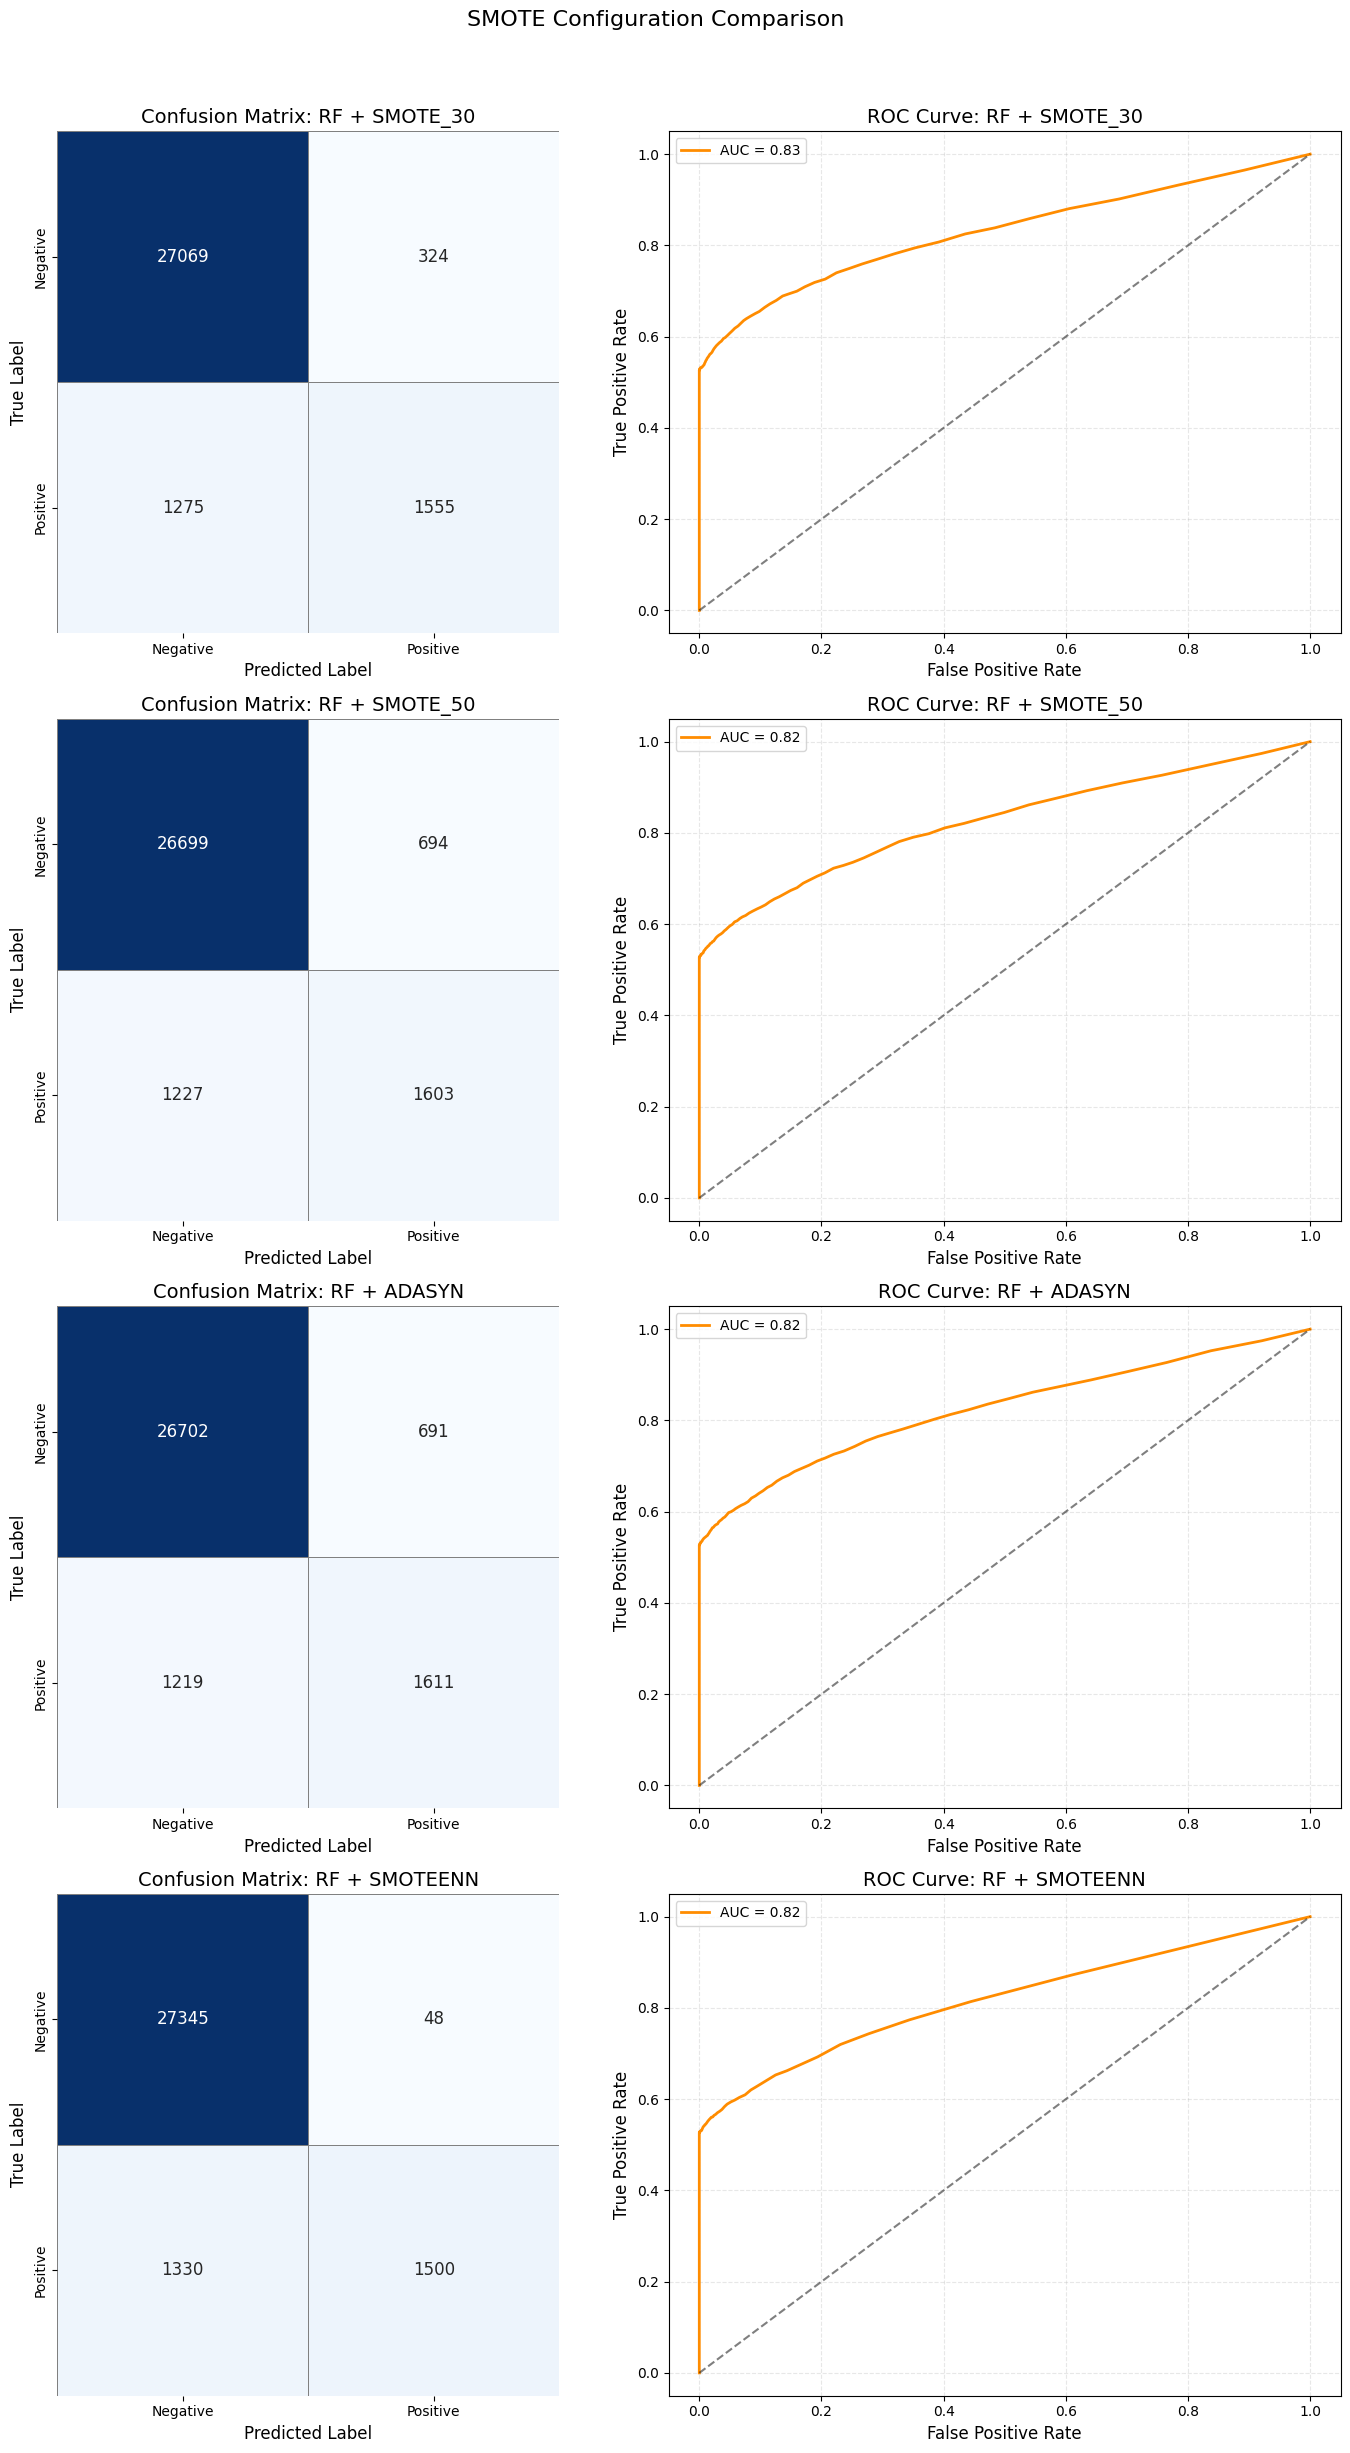

In [ ]:
print("\n📊 VISUALIZING SMOTE MODEL RESULTS")
print("=" * 35)

# Optional class labels
class_labels = ['Negative', 'Positive']  # or your actual classes

# Create a single figure with subplots
n_configs = len(smote_results)
fig, axes = plt.subplots(n_configs, 2, figsize=(14, 6 * n_configs))
fig.suptitle('SMOTE Configuration Comparison', fontsize=16, y=1.02)

for i, result in enumerate(smote_results):
    model_name = result['model_name']
    cm = result['confusion_matrix']
    y_proba = result['y_proba']

    # Confusion Matrix subplot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
                xticklabels=class_labels, yticklabels=class_labels,
                linewidths=0.5, linecolor='gray', ax=axes[i, 0],
                annot_kws={"size": 12})
    axes[i, 0].set_title(f'Confusion Matrix: {model_name}', fontsize=14)
    axes[i, 0].set_xlabel('Predicted Label', fontsize=12)
    axes[i, 0].set_ylabel('True Label', fontsize=12)
    axes[i, 0].tick_params(axis='both', labelsize=10)

    # ROC Curve subplot
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    axes[i, 1].plot(fpr, tpr, label=f'AUC = {auc_score:.2f}', color='darkorange', linewidth=2)
    axes[i, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    axes[i, 1].set_title(f'ROC Curve: {model_name}', fontsize=14)
    axes[i, 1].set_xlabel('False Positive Rate', fontsize=12)
    axes[i, 1].set_ylabel('True Positive Rate', fontsize=12)
    axes[i, 1].legend(fontsize=10)
    axes[i, 1].grid(True, linestyle='--', alpha=0.3)
    axes[i, 1].tick_params(axis='both', labelsize=10)

plt.tight_layout()
plt.show()

## 5. Advanced Models

In [ ]:
print("🚀 ADVANCED MODELS WITH SMOTE")
print("=" * 31)

# Use best SMOTE configuration
best_smote = SMOTE(sampling_strategy=0.3, random_state=42)
X_train_smote, y_train_smote = best_smote.fit_resample(X_train, y_train)
X_train_smote_scaled = scaler.fit_transform(X_train_smote)

advanced_results = []

# 1. Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_smote, y_train_smote)
gb_results = evaluate_model(gb_model, X_train_smote, X_test, y_train_smote, y_test, "Gradient Boosting")
advanced_results.append(gb_results)

# 2. LightGBM
lgb_model = lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
lgb_model.fit(X_train_smote, y_train_smote)
lgb_results = evaluate_model(lgb_model, X_train_smote, X_test, y_train_smote, y_test, "LightGBM")
advanced_results.append(lgb_results)

# 3. Neural Network
nn_model = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    random_state=42,
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.1
)
nn_model.fit(X_train_smote_scaled, y_train_smote)
nn_results = evaluate_model(nn_model, X_train_smote_scaled, X_test_scaled, y_train_smote, y_test, "Neural Network")
advanced_results.append(nn_results)

# 4. Ensemble Model (Voting)
from sklearn.ensemble import VotingClassifier

ensemble_model = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('xgb', xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')),
        ('lgb', lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1))
    ],
    voting='soft'
)
ensemble_model.fit(X_train_smote, y_train_smote)
ensemble_results = evaluate_model(ensemble_model, X_train_smote, X_test, y_train_smote, y_test, "Ensemble")
advanced_results.append(ensemble_results)

🚀 ADVANCED MODELS WITH SMOTE

📊 EVALUATING GRADIENT BOOSTING
--------------------------------
AUC-ROC: 0.8473
AUC-PR:  0.7114
F1-Score: 0.6898
Precision: 0.9973
Recall: 0.5272

Confusion Matrix:
   TN: 27389  FP:    4
   FN: 1338  TP: 1492

📊 EVALUATING LIGHTGBM
-----------------------
AUC-ROC: 0.8436
AUC-PR:  0.7061
F1-Score: 0.6897
Precision: 0.9881
Recall: 0.5297

Confusion Matrix:
   TN: 27375  FP:   18
   FN: 1331  TP: 1499

📊 EVALUATING NEURAL NETWORK
-----------------------------
AUC-ROC: 0.8272
AUC-PR:  0.6551
F1-Score: 0.5325
Precision: 0.5080
Recall: 0.5594

Confusion Matrix:
   TN: 25860  FP: 1533
   FN: 1247  TP: 1583

📊 EVALUATING ENSEMBLE
-----------------------
AUC-ROC: 0.8407
AUC-PR:  0.6982
F1-Score: 0.6846
Precision: 0.9469
Recall: 0.5360

Confusion Matrix:
   TN: 27308  FP:   85
   FN: 1313  TP: 1517


## 6. Model Evaluation

In [ ]:
# Combine all results
all_results = baseline_results + smote_results + advanced_results

# Create comparison DataFrame
comparison_data = []
for result in all_results:
    comparison_data.append({
        'Model': result['model_name'],
        'AUC-ROC': result['auc_roc'],
        'AUC-PR': result['auc_pr'],
        'F1-Score': result['f1_score'],
        'Precision': result['precision'],
        'Recall': result['recall']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('AUC-PR', ascending=False)

print("📊 MODEL PERFORMANCE COMPARISON")
print("=" * 35)
print(comparison_df.round(4).to_string(index=False))

# Best model
best_model_name = comparison_df.iloc[0]['Model']
best_auc_pr = comparison_df.iloc[0]['AUC-PR']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"🎯 BEST AUC-PR: {best_auc_pr:.4f}")

📊 MODEL PERFORMANCE COMPARISON
              Model  AUC-ROC  AUC-PR  F1-Score  Precision  Recall
  Gradient Boosting   0.8473  0.7114    0.6898     0.9973  0.5272
Logistic Regression   0.8390  0.7062    0.6104     0.5334  0.7134
            XGBoost   0.8415  0.7061    0.6095     0.5462  0.6894
           LightGBM   0.8436  0.7061    0.6897     0.9881  0.5297
           Ensemble   0.8407  0.6982    0.6846     0.9469  0.5360
      Random Forest   0.8394  0.6896    0.6875     0.9710  0.5322
      RF + SMOTE_30   0.8280  0.6729    0.6604     0.8276  0.5495
        RF + ADASYN   0.8246  0.6662    0.6278     0.6998  0.5693
      RF + SMOTE_50   0.8241  0.6642    0.6253     0.6979  0.5664
      RF + SMOTEENN   0.8162  0.6555    0.6852     0.9690  0.5300
     Neural Network   0.8272  0.6551    0.5325     0.5080  0.5594

🏆 BEST MODEL: Gradient Boosting
🎯 BEST AUC-PR: 0.7114


## 7. Model Comparison Visualization

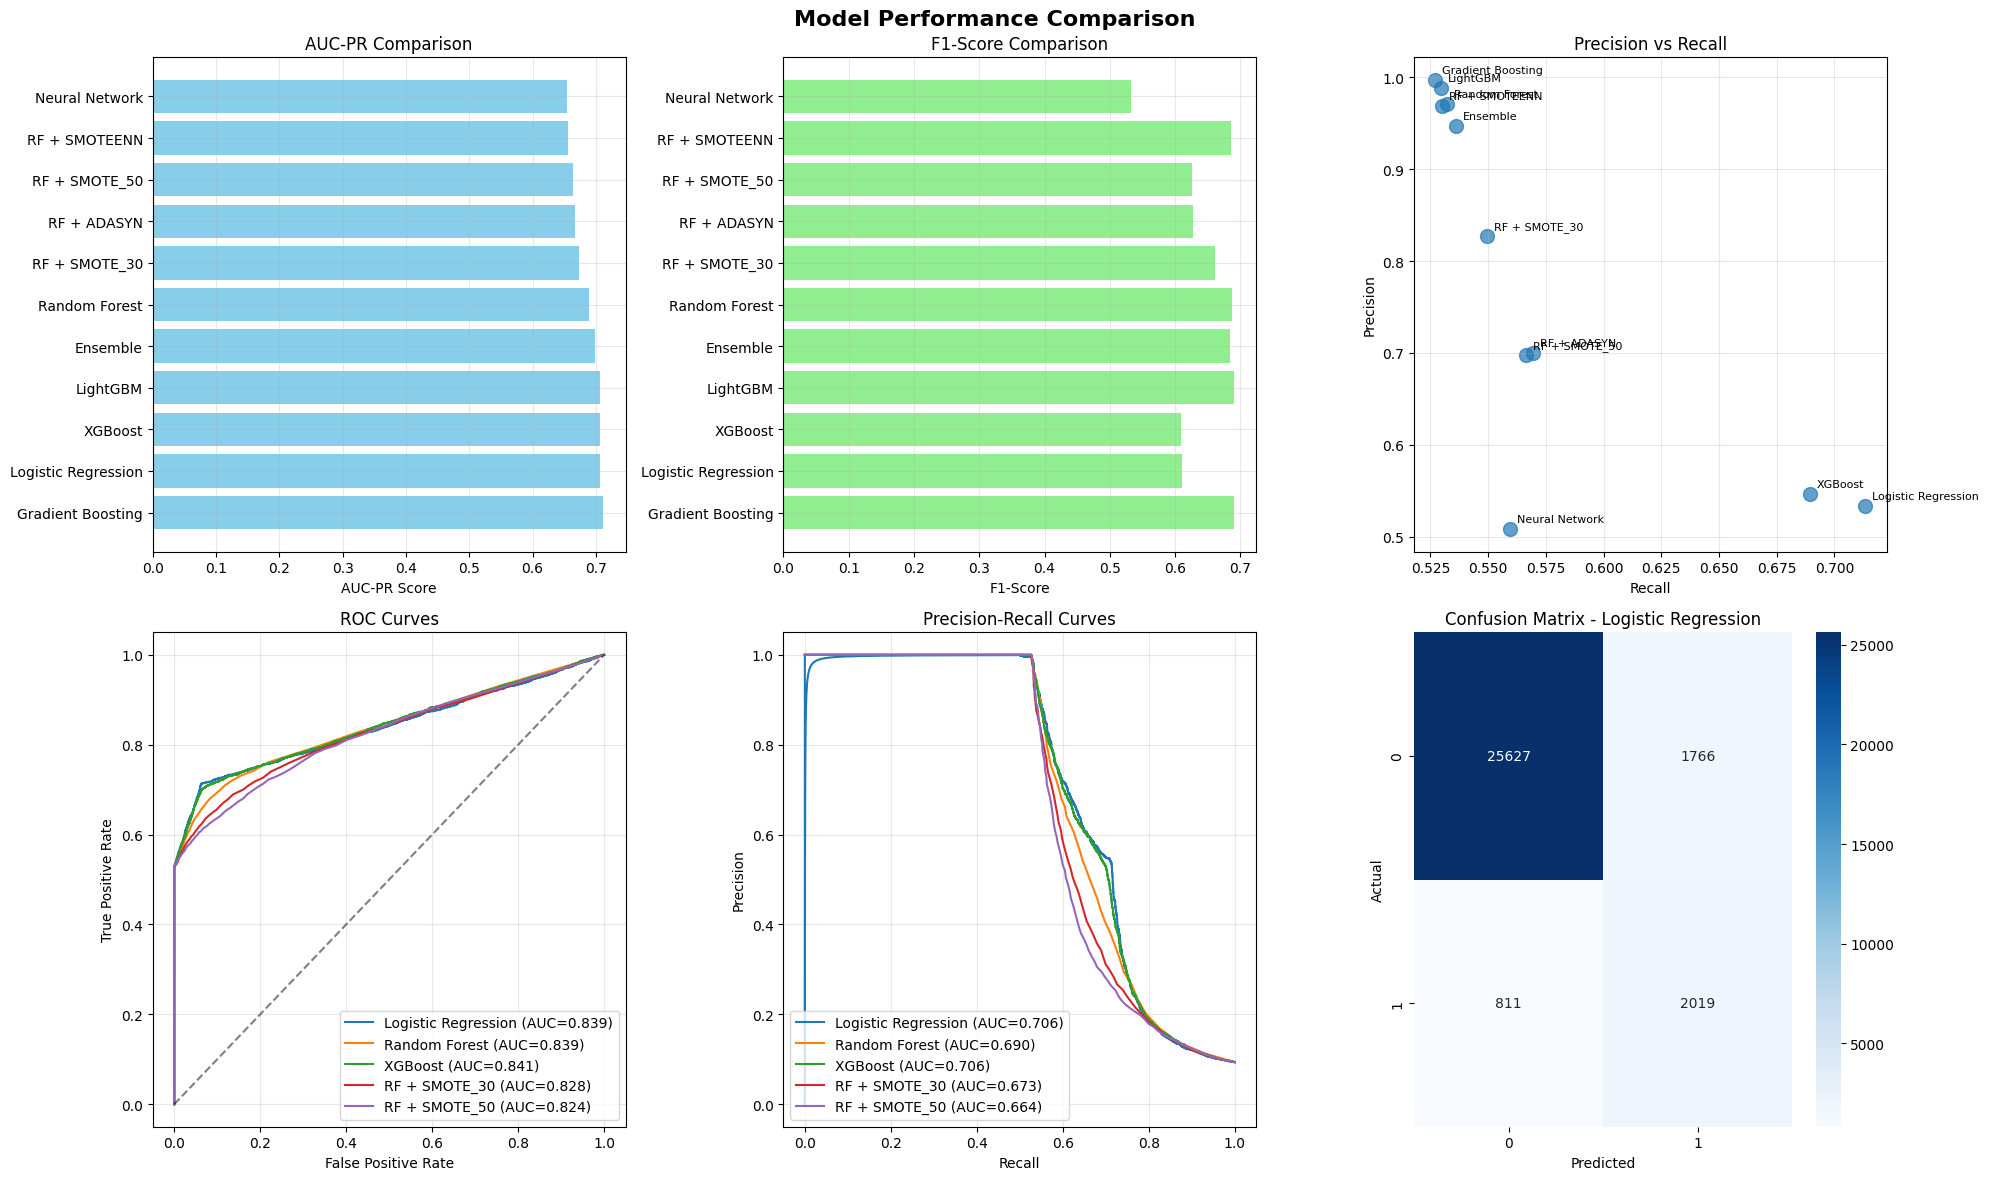

In [ ]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

# 1. AUC-PR Comparison
axes[0, 0].barh(comparison_df['Model'], comparison_df['AUC-PR'], color='skyblue')
axes[0, 0].set_xlabel('AUC-PR Score')
axes[0, 0].set_title('AUC-PR Comparison')
axes[0, 0].grid(True, alpha=0.3)

# 2. F1-Score Comparison
axes[0, 1].barh(comparison_df['Model'], comparison_df['F1-Score'], color='lightgreen')
axes[0, 1].set_xlabel('F1-Score')
axes[0, 1].set_title('F1-Score Comparison')
axes[0, 1].grid(True, alpha=0.3)

# 3. Precision vs Recall
axes[0, 2].scatter(comparison_df['Recall'], comparison_df['Precision'], s=100, alpha=0.7)
for i, model in enumerate(comparison_df['Model']):
    axes[0, 2].annotate(model, (comparison_df.iloc[i]['Recall'], comparison_df.iloc[i]['Precision']),
                       xytext=(5, 5), textcoords='offset points', fontsize=8)
axes[0, 2].set_xlabel('Recall')
axes[0, 2].set_ylabel('Precision')
axes[0, 2].set_title('Precision vs Recall')
axes[0, 2].grid(True, alpha=0.3)

# 4. ROC Curves
for result in all_results[:5]:  # Show top 5 models
    fpr, tpr, _ = roc_curve(y_test, result['y_proba'])
    axes[1, 0].plot(fpr, tpr, label=f"{result['model_name']} (AUC={result['auc_roc']:.3f})")

axes[1, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('ROC Curves')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Precision-Recall Curves
for result in all_results[:5]:  # Show top 5 models
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, result['y_proba'])
    axes[1, 1].plot(recall_curve, precision_curve, label=f"{result['model_name']} (AUC={result['auc_pr']:.3f})")

axes[1, 1].set_xlabel('Recall')
axes[1, 1].set_ylabel('Precision')
axes[1, 1].set_title('Precision-Recall Curves')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 6. Confusion Matrix of Best Model
best_result = all_results[0]  # Assuming first is best
cm = best_result['confusion_matrix']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 2])
axes[1, 2].set_xlabel('Predicted')
axes[1, 2].set_ylabel('Actual')
axes[1, 2].set_title(f'Confusion Matrix - {best_result["model_name"]}')

plt.tight_layout()
plt.show()

## 8. Business Impact Analysis

In [ ]:
def calculate_business_impact(result, y_test, avg_fraud_value=500, investigation_cost=50):
    """
    Calculate business impact of fraud detection model
    """
    cm = result['confusion_matrix']
    tn, fp, fn, tp = cm.ravel()

    # Financial calculations
    fraud_prevented = tp * avg_fraud_value
    fraud_missed = fn * avg_fraud_value
    investigation_costs = (tp + fp) * investigation_cost
    customer_friction_cost = fp * 25  # Cost of declining legitimate transactions

    net_savings = fraud_prevented - investigation_costs - customer_friction_cost
    total_fraud_exposure = (tp + fn) * avg_fraud_value
    roi = (net_savings / total_fraud_exposure) * 100 if total_fraud_exposure > 0 else 0

    return {
        'model_name': result['model_name'],
        'fraud_prevented': fraud_prevented,
        'fraud_missed': fraud_missed,
        'investigation_costs': investigation_costs,
        'customer_friction_cost': customer_friction_cost,
        'net_savings': net_savings,
        'roi': roi,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'tn': tn
    }

print("💰 BUSINESS IMPACT ANALYSIS")
print("=" * 30)

# Calculate business impact for top 5 models
business_impacts = []
for result in all_results[:5]:
    impact = calculate_business_impact(result, y_test)
    business_impacts.append(impact)

    print(f"\n📊 {result['model_name'].upper()}:")
    print(f"   Fraud Prevented: ${impact['fraud_prevented']:,.2f}")
    print(f"   Fraud Missed: ${impact['fraud_missed']:,.2f}")
    print(f"   Investigation Costs: ${impact['investigation_costs']:,.2f}")
    print(f"   Customer Friction: ${impact['customer_friction_cost']:,.2f}")
    print(f"   Net Savings: ${impact['net_savings']:,.2f}")
    print(f"   ROI: {impact['roi']:.1f}%")

# Best model by ROI
best_roi_model = max(business_impacts, key=lambda x: x['roi'])
print(f"\n🏆 BEST ROI MODEL: {best_roi_model['model_name']} ({best_roi_model['roi']:.1f}% ROI)")

💰 BUSINESS IMPACT ANALYSIS

📊 LOGISTIC REGRESSION:
   Fraud Prevented: $1,009,500.00
   Fraud Missed: $405,500.00
   Investigation Costs: $189,250.00
   Customer Friction: $44,150.00
   Net Savings: $776,100.00
   ROI: 54.8%

📊 RANDOM FOREST:
   Fraud Prevented: $753,000.00
   Fraud Missed: $662,000.00
   Investigation Costs: $77,550.00
   Customer Friction: $1,125.00
   Net Savings: $674,325.00
   ROI: 47.7%

📊 XGBOOST:
   Fraud Prevented: $975,500.00
   Fraud Missed: $439,500.00
   Investigation Costs: $178,600.00
   Customer Friction: $40,525.00
   Net Savings: $756,375.00
   ROI: 53.5%

📊 RF + SMOTE_30:
   Fraud Prevented: $777,500.00
   Fraud Missed: $637,500.00
   Investigation Costs: $93,950.00
   Customer Friction: $8,100.00
   Net Savings: $675,450.00
   ROI: 47.7%

📊 RF + SMOTE_50:
   Fraud Prevented: $801,500.00
   Fraud Missed: $613,500.00
   Investigation Costs: $114,850.00
   Customer Friction: $17,350.00
   Net Savings: $669,300.00
   ROI: 47.3%

🏆 BEST ROI MODEL: Logist

## 9. Model Selection and Recommendations

In [ ]:
print("🎯 FINAL MODEL SELECTION AND RECOMMENDATIONS")
print("=" * 48)

# Model selection criteria
print("\n📋 MODEL SELECTION CRITERIA:")
print("1. AUC-PR Score (Primary metric for imbalanced data)")
print("2. Business ROI (Financial impact)")
print("3. Recall (Fraud detection rate)")
print("4. Model interpretability")
print("5. Computational efficiency")

# Top 3 models
top_3_models = comparison_df.head(3)
print(f"\n🏆 TOP 3 MODELS:")
for i, (_, row) in enumerate(top_3_models.iterrows(), 1):
    print(f"   {i}. {row['Model']} - AUC-PR: {row['AUC-PR']:.4f}")

# Final recommendation
recommended_model = top_3_models.iloc[0]['Model']
recommended_auc_pr = top_3_models.iloc[0]['AUC-PR']
recommended_roi = best_roi_model['roi'] if best_roi_model['model_name'] == recommended_model else 'N/A'

print(f"\n✅ RECOMMENDED MODEL: {recommended_model}")
print(f"   AUC-PR Score: {recommended_auc_pr:.4f}")
print(f"   Expected ROI: {recommended_roi}%" if recommended_roi != 'N/A' else "")

print(f"\n📈 IMPLEMENTATION RECOMMENDATIONS:")
print("1. Deploy recommended model in production")
print("2. Implement real-time fraud scoring")
print("3. Set up model monitoring and retraining pipeline")
print("4. Create fraud investigation workflow")
print("5. Establish performance tracking dashboard")

print(f"\n🔄 NEXT STEPS:")
print("1. SHAP analysis for model explainability")
print("2. Feature importance analysis")
print("3. Model deployment preparation")
print("4. A/B testing framework setup")
print("5. Continuous monitoring implementation")

# Save results
results_dir = 'results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
comparison_df.to_csv(os.path.join(results_dir, 'model_comparison.csv'), index=False)
print(f"\n💾 Results saved to {os.path.join(results_dir, 'model_comparison.csv')}")

print(f"\n✅ MODEL BUILDING COMPLETED SUCCESSFULLY!")
print(f"📊 Best Model: {recommended_model}")
print(f"🎯 Best AUC-PR: {recommended_auc_pr:.4f}")
print(f"⏰ Analysis completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

🎯 FINAL MODEL SELECTION AND RECOMMENDATIONS

📋 MODEL SELECTION CRITERIA:
1. AUC-PR Score (Primary metric for imbalanced data)
2. Business ROI (Financial impact)
3. Recall (Fraud detection rate)
4. Model interpretability
5. Computational efficiency

🏆 TOP 3 MODELS:
   1. Gradient Boosting - AUC-PR: 0.7114
   2. Logistic Regression - AUC-PR: 0.7062
   3. XGBoost - AUC-PR: 0.7061

✅ RECOMMENDED MODEL: Gradient Boosting
   AUC-PR Score: 0.7114


📈 IMPLEMENTATION RECOMMENDATIONS:
1. Deploy recommended model in production
2. Implement real-time fraud scoring
3. Set up model monitoring and retraining pipeline
4. Create fraud investigation workflow
5. Establish performance tracking dashboard

🔄 NEXT STEPS:
1. SHAP analysis for model explainability
2. Feature importance analysis
3. Model deployment preparation
4. A/B testing framework setup
5. Continuous monitoring implementation

💾 Results saved to results/model_comparison.csv

✅ MODEL BUILDING COMPLETED SUCCESSFULLY!
📊 Best Model: Gradient Bo

In [ ]:
import joblib
import os

# Ensure the results directory exists
results_dir = 'results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Find the best model name based on AUC-PR from the comparison DataFrame
best_model_name_auc_pr = comparison_df.iloc[0]['Model']

print(f"Attempting to save the best model by AUC-PR: {best_model_name_auc_pr}")

# Retrieve the corresponding model object.
# This assumes the model objects (gb_model, lr_baseline, xgb_baseline, etc.)
# are still available in the notebook's environment from previous executions.
best_model_object = None

if best_model_name_auc_pr == 'Gradient Boosting':
    best_model_object = gb_model
elif best_model_name_auc_pr == 'Logistic Regression':
    best_model_object = lr_baseline
elif best_model_name_auc_pr == 'XGBoost':
    best_model_object = xgb_baseline
elif best_model_name_auc_pr == 'LightGBM':
    best_model_object = lgb_model
elif best_model_name_auc_pr == 'Ensemble':
    best_model_object = ensemble_model

if best_model_object is not None:
    # Define the path to save the model
    # Sanitize the model name for the filename
    model_filename = f"{best_model_name_auc_pr.replace(' ', '_').replace('+', 'plus').lower()}_model.joblib"
    model_save_path = os.path.join(results_dir, model_filename)

    try:
        # Save the model
        joblib.dump(best_model_object, model_save_path)
        print(f"\n💾 Best model ({best_model_name_auc_pr}) saved to {model_save_path}")
    except Exception as e:
        print(f"\n❌ Error saving model {best_model_name_auc_pr}: {e}")

else:
    print(f"\n⚠️ Could not retrieve the model object for {best_model_name_auc_pr}. Cannot save.")

# You can optionally save the best model by ROI as well if it's different
best_roi_model_name = best_roi_model['model_name']
if best_roi_model_name != best_model_name_auc_pr:
    print(f"\nAttempting to save the best model by ROI: {best_roi_model_name}")
    best_roi_model_object = None
    if best_roi_model_name == 'Gradient Boosting':
        best_roi_model_object = gb_model
    elif best_roi_model_name == 'Logistic Regression':
        best_roi_model_object = lr_baseline
    elif best_roi_model_name == 'XGBoost':
        best_roi_model_object = xgb_baseline
    elif best_roi_model_name == 'LightGBM':
        best_roi_model_object = lgb_model
    elif best_roi_model_name == 'Ensemble':
        best_roi_model_object = ensemble_model
    # Add conditions for SMOTE-tuned models if necessary

    if best_roi_model_object is not None:
        model_filename_roi = f"{best_roi_model_name.replace(' ', '_').replace('+', 'plus').lower()}_model_roi.joblib"
        model_save_path_roi = os.path.join(results_dir, model_filename_roi)
        try:
            joblib.dump(best_roi_model_object, model_save_path_roi)
            print(f"\n💾 Best model by ROI ({best_roi_model_name}) saved to {model_save_path_roi}")
        except Exception as e:
            print(f"\n❌ Error saving model {best_roi_model_name}: {e}")
    else:
         print(f"\n⚠️ Could not retrieve the model object for {best_roi_model_name}. Cannot save.")

Attempting to save the best model by AUC-PR: Gradient Boosting

💾 Best model (Gradient Boosting) saved to results/gradient_boosting_model.joblib

Attempting to save the best model by ROI: Logistic Regression

💾 Best model by ROI (Logistic Regression) saved to results/logistic_regression_model_roi.joblib


✅ Successfully loaded model from results/gradient_boosting_model.joblib

📊 Evaluating the loaded model:

📊 EVALUATING LOADED GRADIENT BOOSTING
---------------------------------------
AUC-ROC: 0.8473
AUC-PR:  0.7114
F1-Score: 0.6898
Precision: 0.9973
Recall: 0.5272

Confusion Matrix:
   TN: 27389  FP:    4
   FN: 1338  TP: 1492

📊 Visualizing loaded model results:


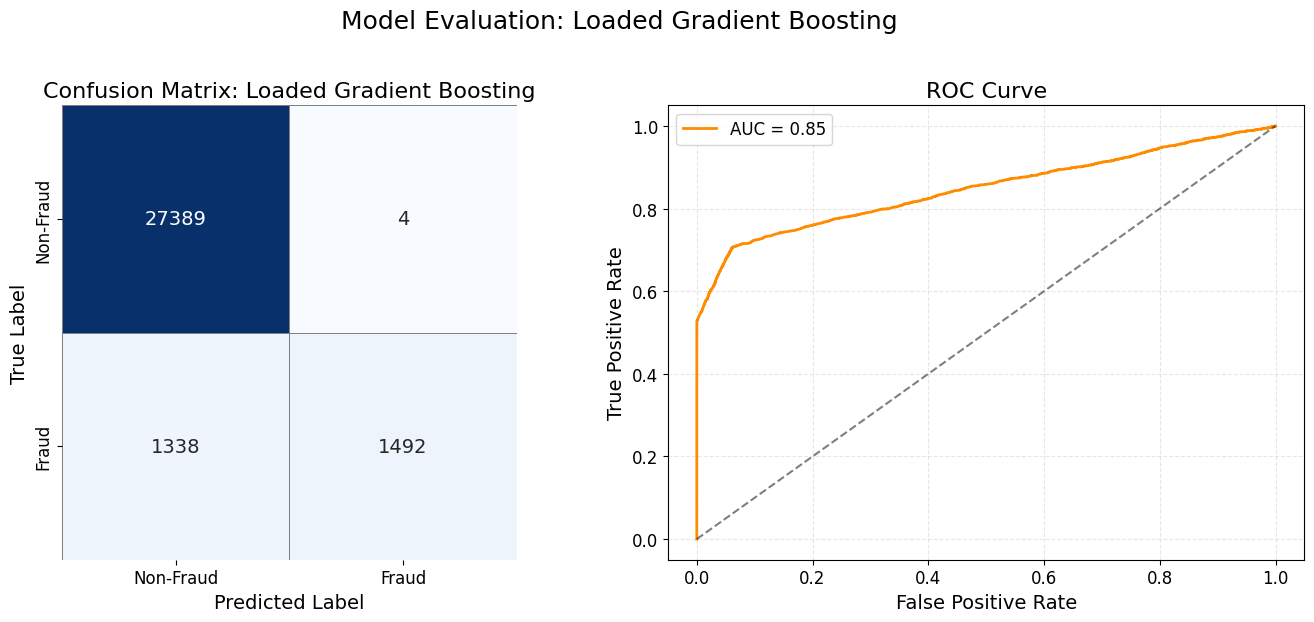

In [25]:
# Load the best model by AUC-PR
# Assuming the best model by AUC-PR was Gradient Boosting and saved as 'gradient_boosting_model.joblib'
model_filename_auc_pr = 'gradient_boosting_model.joblib'
model_path_auc_pr = os.path.join(results_dir, model_filename_auc_pr)

loaded_model_auc_pr = None
try:
    loaded_model_auc_pr = joblib.load(model_path_auc_pr)
    print(f"✅ Successfully loaded model from {model_path_auc_pr}")

    # Use the loaded model to make predictions on the test set
    # If the model was trained on scaled data (like Neural Network), you might need to scale X_test
    # For tree-based models like Gradient Boosting, scaling is usually not required
    if best_model_name_auc_pr in ['Neural Network']:
        X_test_for_prediction = X_test_scaled
    else:
        X_test_for_prediction = X_test

    y_pred_loaded = loaded_model_auc_pr.predict(X_test_for_prediction)
    y_proba_loaded = loaded_model_auc_pr.predict_proba(X_test_for_prediction)[:, 1]

    print("\n📊 Evaluating the loaded model:")
    # Re-evaluate the loaded model on the test set
    loaded_model_results = evaluate_model(
        loaded_model_auc_pr,
        X_train_smote if best_model_name_auc_pr in ['Gradient Boosting', 'LightGBM', 'Ensemble', 'Random Forest'] else X_train, # Pass training data used for fitting if needed by evaluate_model
        X_test_for_prediction,
        y_train_smote if best_model_name_auc_pr in ['Gradient Boosting', 'LightGBM', 'Ensemble', 'Random Forest'] else y_train, # Pass training labels used for fitting
        y_test,
        f"Loaded {best_model_name_auc_pr}"
    )

    # You can further analyze the results here, e.g., plot confusion matrix, ROC curve
    print("\n📊 Visualizing loaded model results:")
    plot_model_results(
        loaded_model_results['confusion_matrix'],
        y_test,
        loaded_model_results['y_proba'],
        f"Loaded {best_model_name_auc_pr}",
        class_labels=['Non-Fraud', 'Fraud']
    )


except FileNotFoundError:
    print(f"❌ Error: Model file not found at {model_path_auc_pr}")
except Exception as e:
    print(f"❌ An error occurred while loading or evaluating the model: {e}")

# Example of using the model for a new data point (assuming you have a new_data_point DataFrame)
# new_data_point = pd.DataFrame({
#     'purchase_value': [50], 'age': [30], 'hour': [10], 'is_weekend': [0], 'is_night': [0],
#     'time_since_signup': [100], 'is_new_user': [0], 'is_high_value': [0],
#     'user_transaction_count': [2], 'device_unique_users': [1], 'is_shared_device': [0],
#     'is_young_user': [0], 'is_ad_source': [1]
# })

# if loaded_model_auc_pr is not None:
#     try:
#         # Preprocess the new data point the same way as the training data
#         # If using a scaler, apply it here
#         # if best_model_name_auc_pr in ['Neural Network']:
#         #     new_data_point_scaled = scaler.transform(new_data_point) # Use the same scaler fitted on training data
#         #     prediction = loaded_model_auc_pr.predict(new_data_point_scaled)
#         #     probability = loaded_model_auc_pr.predict_proba(new_data_point_scaled)[:, 1]
#         # else:
#         #     prediction = loaded_model_auc_pr.predict(new_data_point)
#         #     probability = loaded_model_auc_pr.predict_proba(new_data_point)[:, 1]

#         # print(f"\n📈 Prediction for a new data point: Class {prediction[0]} (Probability: {probability[0]:.4f})")
#     except Exception as e:
#         print(f"\n❌ Error making prediction on new data: {e}")

## Tring the model to predict

In [30]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd

# Dummy model for testing
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Simulate a loaded model (for testing only)
loaded_model = RandomForestClassifier()
loaded_model.fit(np.random.rand(10, 13), np.random.randint(0, 2, 10))

# Descriptions for each feature
feature_descriptions = {
    'purchase_value': "Total value of the transaction (in USD).",
    'age': "Age of the user in years.",
    'hour': "Hour of the transaction (0–23).",
    'is_weekend': "Was the transaction made on a weekend?",
    'is_night': "Was the transaction made during the night?",
    'time_since_signup': "Number of days since user signed up.",
    'is_new_user': "Is this the user’s first or second transaction?",
    'is_high_value': "Is this considered a high-value transaction?",
    'user_transaction_count': "Total number of transactions by this user.",
    'device_unique_users': "Number of users using this device.",
    'is_shared_device': "Is this device shared by multiple users?",
    'is_young_user': "Is the user age below 25?",
    'is_ad_source': "Did the user come via an ad campaign?"
}

feature_names = list(feature_descriptions.keys())

input_widgets = {}
for feature in feature_names:
    tooltip = feature_descriptions[feature]
    label = feature.replace('_', ' ').title() + ':'

    if feature in ['purchase_value', 'age', 'time_since_signup', 'user_transaction_count', 'device_unique_users']:
        input_widgets[feature] = widgets.FloatText(
            description=label, value=0.0, description_tooltip=tooltip
        )
    elif feature == 'hour':
        input_widgets[feature] = widgets.BoundedIntText(
            description=label, value=0, min=0, max=23, description_tooltip=tooltip
        )
    else:
        input_widgets[feature] = widgets.Checkbox(
            description=label, value=False, description_tooltip=tooltip
        )

# Button and Output
predict_button = widgets.Button(description="Predict Fraud", button_style='info')
output_widget = widgets.Output()

# Callback function
def on_predict_button_click(b):
    with output_widget:
        clear_output()
        try:
            values = {f: w.value for f, w in input_widgets.items()}
            data = pd.DataFrame([values])[feature_names]
            prediction = loaded_model.predict(data)
            proba = loaded_model.predict_proba(data)[:, 1]
            print("\n📈 Prediction Results:")
            print(f"   Predicted Class: {'Fraud' if prediction[0] == 1 else 'Non-Fraud'}")
            print(f"   Fraud Probability: {proba[0]:.4f}")
        except Exception as e:
            print(f"❌ Error: {e}")

predict_button.on_click(on_predict_button_click)

# Display everything
form = widgets.VBox(list(input_widgets.values()) + [predict_button, output_widget])
display(form)
